# MLP-Mixer Network with Boundary (permutation invariant) Loss

Note: Data loaded as (alpha, omega1, omega2, omega3, u, v)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from types import SimpleNamespace
import os
import pickle

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load junction dataset

In [3]:
 # print(os.listdir(data_folder))

data_folder = 'Data/grayscale_junctions/'


# Start with purely junction images
# with open(data_folder + 'junction_data_24_10000_grey_multicolor_noiseless_centered.pkl','rb') as f:
# with open(data_folder + 'junction_data_24_20000_grey_multicolor_noiseless_centered.pkl','rb') as f:
with open(data_folder + 'M-junction_data_12_50000_grey_multicolor_noise_level_.2_center_range_1.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']

### Start with M-junction (alpha, omega1, omega2, omega3, u, v) parameterization

torch.Size([500, 6])


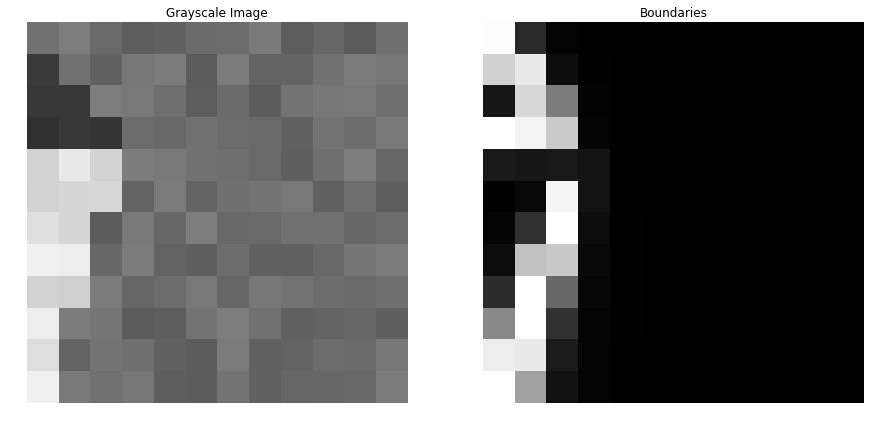

In [18]:
class JunctionDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, params, boundaries, transform=None):
        self.images = images
        self.params = params
        self.boundaries = boundaries
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]

        if self.transform:
            image = self.transform(image)
        
        # Rpresentation: alpha [orientation], omega1, omega2, omega3, u, v
        boundary = boundaries[index]

        return image, self.params[index].squeeze(), boundary

    def __len__(self):
        return len(self.images)
    
    
# Make training and testing data
junc_data = JunctionDataset(wedges_grey, params, boundaries)#, transform=trainTransform)
data_size = len(junc_data)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(junc_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


data = next(iter(test_loader))
wedge_image = data[0]
boundary_image = data[2]

_, H, W = wedge_image[0].shape

# print(data[1][0])

print(data[1].shape)

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(121)
plt.imshow(wedge_image[0].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(122)
plt.imshow(boundary_image[0].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');

# Define function to produce junction images from outputs

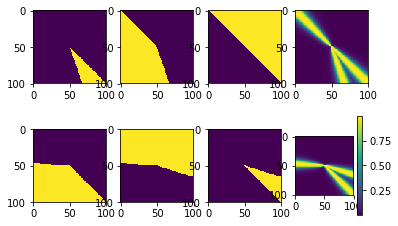

In [5]:
from multijunction import MultiJunction
    
opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  100    # Number of pixels in each dimension of square patch
opts.delta                    =  .01   # Dirac delta relaxation parameter for rendering boundary maps

# create 3-junction with default properties
order = 3
centers = torch.zeros((2,2)).to(dev)
angles = torch.tensor((torch.pi/4, torch.pi/4)).to(dev)
solid_angles = torch.tensor([[.1,.6,.7],[.5,.7,.1]]).to(dev)

jn = MultiJunction(order, dev, centers, angles, solid_angles)
    
    
# render indicator functions of all wedges and boundaries
w = jn.render_wedges(opts,dev).cpu()
b = jn.render_boundaries(opts,dev).cpu()

plt.figure()
plt.subplot(241)
plt.imshow(w[0,:,:,0])
plt.subplot(242)
plt.imshow(w[0,:,:,1])
plt.subplot(243)
plt.imshow(w[0,:,:,2])
plt.subplot(244)
plt.imshow(b[0,:,:])
plt.subplot(245)
plt.imshow(w[1,:,:,0])
plt.subplot(246)
plt.imshow(w[1,:,:,1])
plt.subplot(247)
plt.imshow(w[1,:,:,2])
plt.subplot(248)
plt.imshow(b[1,:,:])
plt.colorbar()



### Let's represent the output of the network as
### (cos(alpha),sin(alpha),omega1,omega2,omega3,u,v)

In [20]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

pair = lambda x: x if isinstance(x, tuple) else (x, x)

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )

class NormalizeOutputs(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # Output of neural network:
        # cos(alpha),sin(alpha),omega1, omega2, omega3, u, v
        
        # First map the orientation sin/cosine to be between -1 and 1
        x[:,:2] = self.tanh(x[:,:2])
        
        # Then normalize  so that cos(theta)**2 + sin(theta)**2 = 1    
        out1 = x[:,:2]/(torch.sqrt(x[:,0]**2 + x[:,1]**2)).unsqueeze(1)
        
        # Next, map the three angles to be between 0 and 1, and then scale to sum to 2*pi
        xs = self.sigmoid(x[:,2:5])
        
        out2 = xs/torch.sum(xs,1).unsqueeze(1) * 2*torch.pi
       
        return torch.cat((out1,out2,x[:,5:]),axis=1)
    
    

def MLPMixer(*, image_size, channels, patch_size, dim, depth, num_classes, expansion_factor = 4, expansion_factor_token = 0.5, dropout = 0.):
    image_h, image_w = pair(image_size)
    assert (image_h % patch_size) == 0 and (image_w % patch_size) == 0, 'image must be divisible by patch size'
    num_patches = (image_h // patch_size) * (image_w // patch_size)
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        Reduce('b n c -> b c', 'mean'),
        nn.Linear(dim, num_classes),
        NormalizeOutputs()
    )

model = MLPMixer(
    image_size = H,
    channels = 1,
    patch_size = 2,
    dim = 128,
    depth = 3,
    num_classes = 7
)

# img = torch.randn(1, 3, 256, 256)
# pred = model(img) # (1, 1000)
model = model.to(dev)

summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1                [-1, 36, 4]               0
            Linear-2              [-1, 36, 128]             640
         LayerNorm-3              [-1, 36, 128]             256
            Conv1d-4             [-1, 144, 128]           5,328
              GELU-5             [-1, 144, 128]               0
           Dropout-6             [-1, 144, 128]               0
            Conv1d-7              [-1, 36, 128]           5,220
           Dropout-8              [-1, 36, 128]               0
   PreNormResidual-9              [-1, 36, 128]               0
        LayerNorm-10              [-1, 36, 128]             256
           Linear-11               [-1, 36, 64]           8,256
             GELU-12               [-1, 36, 64]               0
          Dropout-13               [-1, 36, 64]               0
           Linear-14              [-1, 

In [37]:
# Now let's train the initial network 

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 300

mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  20    # Number of pixels in each dimension of square patch
opts.delta                    =  .1   # Dirac delta relaxation parameter for rendering boundary maps

 
def get_loss(output_line_params, output_gt, opts, dev):
    
        # render ground truth boundaries (allows you to vary opts parameters rather than preload)
        jn_gt = MultiJunction(3, dev, output_gt[:,4:], output_gt[:,0], output_gt[:,1:4])
        b_gt = jn_gt.render_boundaries(opts,dev)

        # render output boundaries
        output_alpha = torch.atan2(output_line_params[:,1],output_line_params[:,0])
        jn = MultiJunction(3, dev, output_line_params[:,5:], output_alpha, output_line_params[:,2:5])
        b_output = jn.render_boundaries(opts,dev)
        
        loss = mse_loss(b_output,b_gt) 
        
        return loss

def forward_pass(data, opts, dev, training):
    
    # Load inputs from data
    inputs, output_gt, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()
    
    new_inputs = inputs 
    
    # forward pass to get outputs
    output_line_params = model(inputs)
    
    loss = get_loss(output_line_params,output_gt, opts, dev)
    
    if training:

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()
        
    return output_line_params, loss#, angles_gt_oh
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 50:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    model.train();
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        _,loss = forward_pass(data, opts, dev, training = 1)

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1    

            _,loss = forward_pass(data, opts, dev, training = 0)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)

    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

Epoch: 1, Avg. Train Loss: 0.05666676676448654, Avg. Test Loss: 0.04893152788281441
Epoch: 2, Avg. Train Loss: 0.04729645892101176, Avg. Test Loss: 0.0471295528113842
Epoch: 3, Avg. Train Loss: 0.05035467616775457, Avg. Test Loss: 0.04747272655367851
Epoch: 4, Avg. Train Loss: 0.047719347608440064, Avg. Test Loss: 0.048087138682603836
Epoch: 5, Avg. Train Loss: 0.04447606131434441, Avg. Test Loss: 0.04260417819023132
Epoch: 6, Avg. Train Loss: 0.04318261611111024, Avg. Test Loss: 0.041652094572782516
Epoch: 7, Avg. Train Loss: 0.04368411775897531, Avg. Test Loss: 0.046398717910051346
Epoch: 8, Avg. Train Loss: 0.04074699181844207, Avg. Test Loss: 0.040838636457920074
Epoch: 9, Avg. Train Loss: 0.038145450239672384, Avg. Test Loss: 0.038303960114717484
Epoch: 10, Avg. Train Loss: 0.03782917686245021, Avg. Test Loss: 0.03851044550538063
Epoch: 11, Avg. Train Loss: 0.03838891180999139, Avg. Test Loss: 0.037911660969257355
Epoch: 12, Avg. Train Loss: 0.04208192647818257, Avg. Test Loss: 0.

KeyboardInterrupt: 

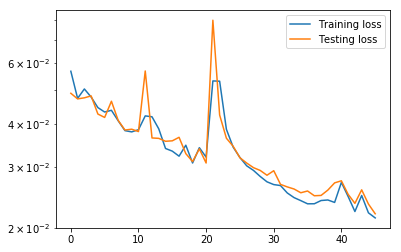

In [38]:
plt.figure()
plt.semilogy(np.arange(0,len(train_loss_over_time)),train_loss_over_time)
plt.semilogy(np.arange(0,len(test_loss_over_time)),test_loss_over_time)
plt.legend(['Training loss', 'Testing loss'])

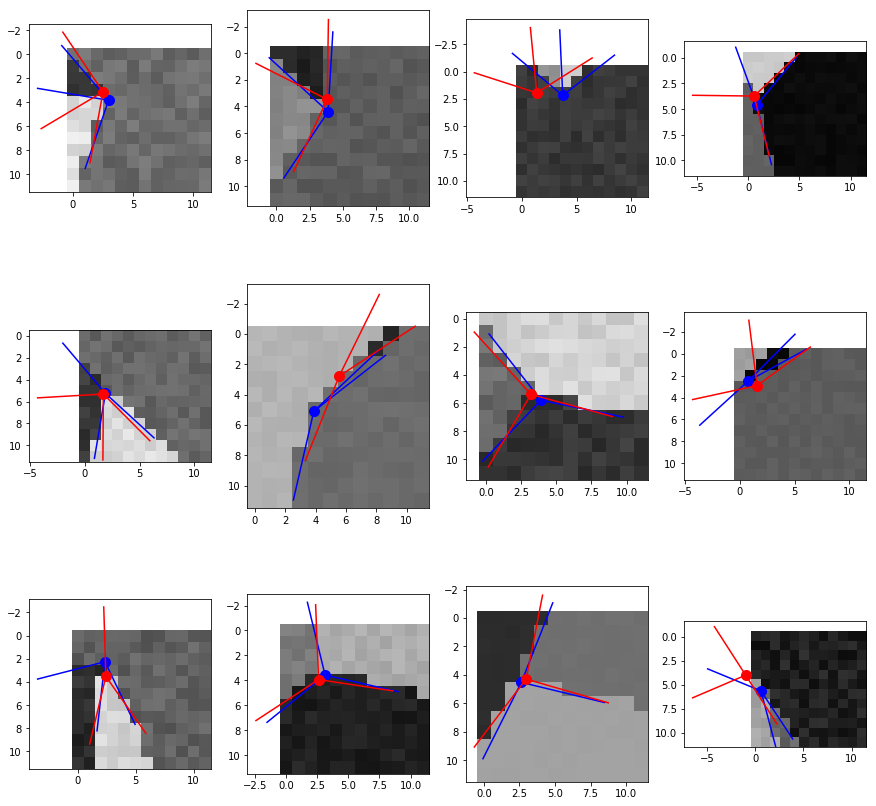

In [41]:
# Visualize the outputs

# First load one batch of outputs

model.eval();

data = next(iter(test_loader))

inputs, output_gt, _ = data
output_gt = output_gt.to(dev)

# forward pass to get outputs
outputs,_ = forward_pass(data, opts, dev, 0)

outputs = outputs.cpu().detach()
gt = output_gt.cpu().squeeze()


plt.figure(figsize=(15,15))

# Plot 10 examples of the outputs    
for ii in range(12):
    
    plt.subplot(3,4,ii+1)

    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray',vmin=0,vmax=1)

    center_gt = gt[ii][4:]*torch.tensor((H/2,W/2)) + torch.tensor((H/2,W/2))

    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    
    gt_angles = torch.stack((gt[:,0],gt[:,0]+gt[:,1],gt[:,0]+gt[:,1]+gt[:,2]),axis=1)
    
    line1_end = (center_gt + H/2*np.array([np.cos(gt_angles[ii][0]),np.sin(gt_angles[ii][0])]))
    line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_gt + H/2*np.array([np.cos(gt_angles[ii][1]),np.sin(gt_angles[ii][1])]))
    line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_gt + H/2*np.array([np.cos(gt_angles[ii][2]),np.sin(gt_angles[ii][2])]))
    line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-b')
    plt.plot(line2[0,:],line2[1,:],'-b')
    plt.plot(line3[0,:],line3[1,:],'-b')
    
    
    center_output = outputs[ii,5:]*torch.tensor((H/2,W/2)) + torch.tensor((H/2,W/2))
    
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    alpha = torch.atan2(outputs[:,1],outputs[:,0])
    
    output_angles = torch.stack((alpha, alpha + outputs[:,2],alpha + outputs[:,2] + outputs[:,3]),axis=1)
    
    line1_end = (center_output + H/2*np.array([np.cos(output_angles[ii][0]),np.sin(output_angles[ii][0])]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + H/2*np.array([np.cos(output_angles[ii][1]),np.sin(output_angles[ii][1])]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + H/2*np.array([np.cos(output_angles[ii][2]),np.sin(output_angles[ii][2])]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')



In [42]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

pair = lambda x: x if isinstance(x, tuple) else (x, x)

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )

class NormalizeOutputs(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # Output of neural network:
        # cos(alpha),sin(alpha),omega1, omega2, omega3, u, v
        
        # First map the orientation sin/cosine to be between -1 and 1
        x[:,:2] = self.tanh(x[:,:2])
        
        # Then normalize  so that cos(theta)**2 + sin(theta)**2 = 1    
        out1 = x[:,:2]/(torch.sqrt(x[:,0]**2 + x[:,1]**2)).unsqueeze(1)
        
        # Next, map the three angles to be between 0 and 1, and then scale to sum to 2*pi
        xs = self.sigmoid(x[:,2:5])
        
        out2 = xs/torch.sum(xs,1).unsqueeze(1) * 2*torch.pi
       
        return torch.cat((out1,out2,x[:,5:]),axis=1)
    
    

def MLPMixer(*, image_size, channels, patch_size, dim, depth, num_classes, expansion_factor = 4, expansion_factor_token = 0.5, dropout = 0.):
    image_h, image_w = pair(image_size)
    assert (image_h % patch_size) == 0 and (image_w % patch_size) == 0, 'image must be divisible by patch size'
    num_patches = (image_h // patch_size) * (image_w // patch_size)
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        Reduce('b n c -> b c', 'mean'),
        nn.Linear(dim, num_classes),
        NormalizeOutputs()
    )

model = MLPMixer(
    image_size = H,
    channels = 1,
    patch_size = 2,
    dim = 128,
    depth = 6,
    num_classes = 7
)

# img = torch.randn(1, 3, 256, 256)
# pred = model(img) # (1, 1000)
model = model.to(dev)

summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1                [-1, 36, 4]               0
            Linear-2              [-1, 36, 128]             640
         LayerNorm-3              [-1, 36, 128]             256
            Conv1d-4             [-1, 144, 128]           5,328
              GELU-5             [-1, 144, 128]               0
           Dropout-6             [-1, 144, 128]               0
            Conv1d-7              [-1, 36, 128]           5,220
           Dropout-8              [-1, 36, 128]               0
   PreNormResidual-9              [-1, 36, 128]               0
        LayerNorm-10              [-1, 36, 128]             256
           Linear-11               [-1, 36, 64]           8,256
             GELU-12               [-1, 36, 64]               0
          Dropout-13               [-1, 36, 64]               0
           Linear-14              [-1, 

In [43]:
# Now let's train the initial network 

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 300

mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  20    # Number of pixels in each dimension of square patch
opts.delta                    =  .1   # Dirac delta relaxation parameter for rendering boundary maps

 
def get_loss(output_line_params, output_gt, opts, dev):
    
        # render ground truth boundaries (allows you to vary opts parameters rather than preload)
        jn_gt = MultiJunction(3, dev, output_gt[:,4:], output_gt[:,0], output_gt[:,1:4])
        b_gt = jn_gt.render_boundaries(opts,dev)

        # render output boundaries
        output_alpha = torch.atan2(output_line_params[:,1],output_line_params[:,0])
        jn = MultiJunction(3, dev, output_line_params[:,5:], output_alpha, output_line_params[:,2:5])
        b_output = jn.render_boundaries(opts,dev)
        
        loss = mse_loss(b_output,b_gt) 
        
        return loss

def forward_pass(data, opts, dev, training):
    
    # Load inputs from data
    inputs, output_gt, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()
    
    new_inputs = inputs 
    
    # forward pass to get outputs
    output_line_params = model(inputs)
    
    loss = get_loss(output_line_params,output_gt, opts, dev)
    
    if training:

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()
        
    return output_line_params, loss#, angles_gt_oh
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 50:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    model.train();
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        _,loss = forward_pass(data, opts, dev, training = 1)

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1    

            _,loss = forward_pass(data, opts, dev, training = 0)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)

    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

Epoch: 1, Avg. Train Loss: 0.21607686842189117, Avg. Test Loss: 0.15609417855739594
Epoch: 2, Avg. Train Loss: 0.14605780796093099, Avg. Test Loss: 0.12566111981868744
Epoch: 3, Avg. Train Loss: 0.0923399611869279, Avg. Test Loss: 0.062282390892505646
Epoch: 4, Avg. Train Loss: 0.05849349726648892, Avg. Test Loss: 0.05445120856165886
Epoch: 5, Avg. Train Loss: 0.05009548536994878, Avg. Test Loss: 0.04728749766945839
Epoch: 6, Avg. Train Loss: 0.05110190488836345, Avg. Test Loss: 0.04800771176815033
Epoch: 7, Avg. Train Loss: 0.04371227950734251, Avg. Test Loss: 0.04118752479553223
Epoch: 8, Avg. Train Loss: 0.04131675007588723, Avg. Test Loss: 0.038512032479047775
Epoch: 9, Avg. Train Loss: 0.03995118421666762, Avg. Test Loss: 0.03752649202942848
Epoch: 10, Avg. Train Loss: 0.037200725210063595, Avg. Test Loss: 0.03487372025847435
Epoch: 11, Avg. Train Loss: 0.033693232562612085, Avg. Test Loss: 0.03181590512394905
Epoch: 12, Avg. Train Loss: 0.03255182011600803, Avg. Test Loss: 0.0321

Epoch: 97, Avg. Train Loss: 0.016699990509625742, Avg. Test Loss: 0.015889683738350868
Epoch: 98, Avg. Train Loss: 0.01581306151826592, Avg. Test Loss: 0.017006121575832367
Epoch: 99, Avg. Train Loss: 0.024701756052672864, Avg. Test Loss: 0.05095773935317993
Epoch: 100, Avg. Train Loss: 0.029968982562422752, Avg. Test Loss: 0.022370541468262672
Epoch: 101, Avg. Train Loss: 0.01930241676814416, Avg. Test Loss: 0.023608246818184853
Epoch: 102, Avg. Train Loss: 0.01855833359500941, Avg. Test Loss: 0.018400974571704865
Epoch: 103, Avg. Train Loss: 0.017896783801124378, Avg. Test Loss: 0.017292939126491547
Epoch: 104, Avg. Train Loss: 0.01896242228720118, Avg. Test Loss: 0.02035333961248398
Epoch: 105, Avg. Train Loss: 0.017088608038337793, Avg. Test Loss: 0.017147578299045563
Epoch: 106, Avg. Train Loss: 0.01718562335214194, Avg. Test Loss: 0.018559597432613373
Epoch: 107, Avg. Train Loss: 0.015816168465158518, Avg. Test Loss: 0.016731582581996918
Epoch: 108, Avg. Train Loss: 0.02346795386

KeyboardInterrupt: 

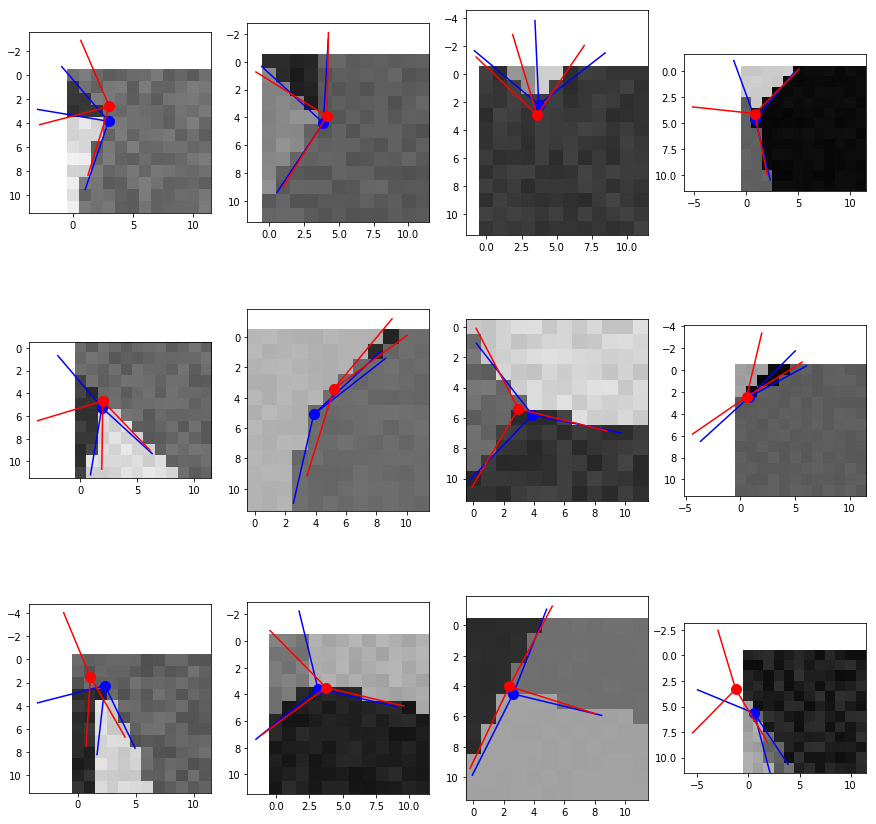

In [44]:
# Visualize the outputs

# First load one batch of outputs

model.eval();

data = next(iter(test_loader))

inputs, output_gt, _ = data
output_gt = output_gt.to(dev)

# forward pass to get outputs
outputs,_ = forward_pass(data, opts, dev, 0)

outputs = outputs.cpu().detach()
gt = output_gt.cpu().squeeze()


plt.figure(figsize=(15,15))

# Plot 10 examples of the outputs    
for ii in range(12):
    
    plt.subplot(3,4,ii+1)

    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray',vmin=0,vmax=1)

    center_gt = gt[ii][4:]*torch.tensor((H/2,W/2)) + torch.tensor((H/2,W/2))

    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    
    gt_angles = torch.stack((gt[:,0],gt[:,0]+gt[:,1],gt[:,0]+gt[:,1]+gt[:,2]),axis=1)
    
    line1_end = (center_gt + H/2*np.array([np.cos(gt_angles[ii][0]),np.sin(gt_angles[ii][0])]))
    line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_gt + H/2*np.array([np.cos(gt_angles[ii][1]),np.sin(gt_angles[ii][1])]))
    line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_gt + H/2*np.array([np.cos(gt_angles[ii][2]),np.sin(gt_angles[ii][2])]))
    line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-b')
    plt.plot(line2[0,:],line2[1,:],'-b')
    plt.plot(line3[0,:],line3[1,:],'-b')
    
    
    center_output = outputs[ii,5:]*torch.tensor((H/2,W/2)) + torch.tensor((H/2,W/2))
    
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    alpha = torch.atan2(outputs[:,1],outputs[:,0])
    
    output_angles = torch.stack((alpha, alpha + outputs[:,2],alpha + outputs[:,2] + outputs[:,3]),axis=1)
    
    line1_end = (center_output + H/2*np.array([np.cos(output_angles[ii][0]),np.sin(output_angles[ii][0])]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + H/2*np.array([np.cos(output_angles[ii][1]),np.sin(output_angles[ii][1])]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + H/2*np.array([np.cos(output_angles[ii][2]),np.sin(output_angles[ii][2])]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')



In [48]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

pair = lambda x: x if isinstance(x, tuple) else (x, x)

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )

class NormalizeOutputs(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # Output of neural network:
        # cos(alpha),sin(alpha),omega1, omega2, omega3, u, v
        
        # First map the orientation sin/cosine to be between -1 and 1
        x[:,:2] = self.tanh(x[:,:2])
        
        # Then normalize  so that cos(theta)**2 + sin(theta)**2 = 1    
        out1 = x[:,:2]/(torch.sqrt(x[:,0]**2 + x[:,1]**2)).unsqueeze(1)
        
        # Next, map the three angles to be between 0 and 1, and then scale to sum to 2*pi
        xs = self.sigmoid(x[:,2:5])
        
        out2 = xs/torch.sum(xs,1).unsqueeze(1) * 2*torch.pi
       
        return torch.cat((out1,out2,x[:,5:]),axis=1)
    
    

def MLPMixer(*, image_size, channels, patch_size, dim, depth, num_classes, expansion_factor = 4, expansion_factor_token = 0.5, dropout = 0.):
    image_h, image_w = pair(image_size)
    assert (image_h % patch_size) == 0 and (image_w % patch_size) == 0, 'image must be divisible by patch size'
    num_patches = (image_h // patch_size) * (image_w // patch_size)
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        Reduce('b n c -> b c', 'mean'),
        nn.Linear(dim, num_classes),
        NormalizeOutputs()
    )

model = MLPMixer(
    image_size = H,
    channels = 1,
    patch_size = 2,
    dim = 64,
    depth = 3,
    num_classes = 7
)

# img = torch.randn(1, 3, 256, 256)
# pred = model(img) # (1, 1000)
model = model.to(dev)

summary(model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1                [-1, 36, 4]               0
            Linear-2               [-1, 36, 64]             320
         LayerNorm-3               [-1, 36, 64]             128
            Conv1d-4              [-1, 144, 64]           5,328
              GELU-5              [-1, 144, 64]               0
           Dropout-6              [-1, 144, 64]               0
            Conv1d-7               [-1, 36, 64]           5,220
           Dropout-8               [-1, 36, 64]               0
   PreNormResidual-9               [-1, 36, 64]               0
        LayerNorm-10               [-1, 36, 64]             128
           Linear-11               [-1, 36, 32]           2,080
             GELU-12               [-1, 36, 32]               0
          Dropout-13               [-1, 36, 32]               0
           Linear-14               [-1,

Epoch: 1, Avg. Train Loss: 0.16495611132944332, Avg. Test Loss: 0.10178560763597488
Epoch: 2, Avg. Train Loss: 0.09899553393616396, Avg. Test Loss: 0.08421765267848969
Epoch: 3, Avg. Train Loss: 0.0760234139421407, Avg. Test Loss: 0.06921748071908951
Epoch: 4, Avg. Train Loss: 0.06582992239033475, Avg. Test Loss: 0.06216451898217201
Epoch: 5, Avg. Train Loss: 0.06038214397781035, Avg. Test Loss: 0.05713202804327011
Epoch: 6, Avg. Train Loss: 0.055056862796054165, Avg. Test Loss: 0.05322461947798729
Epoch: 7, Avg. Train Loss: 0.05226015225052834, Avg. Test Loss: 0.05260332301259041
Epoch: 8, Avg. Train Loss: 0.05021737892838085, Avg. Test Loss: 0.0499216765165329
Epoch: 9, Avg. Train Loss: 0.0483380959752728, Avg. Test Loss: 0.04826653376221657
Epoch: 10, Avg. Train Loss: 0.04779805847827126, Avg. Test Loss: 0.04459672048687935
Epoch: 11, Avg. Train Loss: 0.045604765152229984, Avg. Test Loss: 0.04700344800949097
Epoch: 12, Avg. Train Loss: 0.04472002023283173, Avg. Test Loss: 0.04407134

Epoch: 97, Avg. Train Loss: 0.02603592936168699, Avg. Test Loss: 0.023950157687067986
Epoch: 98, Avg. Train Loss: 0.025042510449009785, Avg. Test Loss: 0.025302371010184288
Epoch: 99, Avg. Train Loss: 0.023518150803797384, Avg. Test Loss: 0.023989038541913033
Epoch: 100, Avg. Train Loss: 0.023020183032049852, Avg. Test Loss: 0.02540225349366665
Epoch: 101, Avg. Train Loss: 0.023274032968808624, Avg. Test Loss: 0.023779278621077538
Epoch: 102, Avg. Train Loss: 0.023083027539884345, Avg. Test Loss: 0.02327318675816059
Epoch: 103, Avg. Train Loss: 0.02220300403149689, Avg. Test Loss: 0.022280968725681305
Epoch: 104, Avg. Train Loss: 0.02133125128114925, Avg. Test Loss: 0.02241169475018978
Epoch: 105, Avg. Train Loss: 0.020988068203715717, Avg. Test Loss: 0.022620789706707
Epoch: 106, Avg. Train Loss: 0.021077457508620095, Avg. Test Loss: 0.021884696558117867
Epoch: 107, Avg. Train Loss: 0.02487542982048848, Avg. Test Loss: 0.024772565811872482
Epoch: 108, Avg. Train Loss: 0.02595092042842

Epoch: 192, Avg. Train Loss: 0.019714874752304132, Avg. Test Loss: 0.02114887163043022
Epoch: 193, Avg. Train Loss: 0.025028495424810577, Avg. Test Loss: 0.02372022345662117
Epoch: 194, Avg. Train Loss: 0.02091962309444652, Avg. Test Loss: 0.022351140156388283
Epoch: 195, Avg. Train Loss: 0.021100843719699804, Avg. Test Loss: 0.020964039489626884
Epoch: 196, Avg. Train Loss: 0.021190730811041943, Avg. Test Loss: 0.023780889809131622
Epoch: 197, Avg. Train Loss: 0.031155005426091308, Avg. Test Loss: 0.026788238435983658
Epoch: 198, Avg. Train Loss: 0.037568415635648895, Avg. Test Loss: 0.032632675021886826
Epoch: 199, Avg. Train Loss: 0.02698711086721981, Avg. Test Loss: 0.024219417944550514
Epoch: 200, Avg. Train Loss: 0.022908383914652993, Avg. Test Loss: 0.02332991361618042
Epoch: 201, Avg. Train Loss: 0.02291387036881026, Avg. Test Loss: 0.022311052307486534
Epoch: 202, Avg. Train Loss: 0.020476272526909322, Avg. Test Loss: 0.02101878449320793
Epoch: 203, Avg. Train Loss: 0.01980127

Epoch: 286, Avg. Train Loss: 0.01826462999862783, Avg. Test Loss: 0.01862478069961071
Epoch: 287, Avg. Train Loss: 0.01985778668347527, Avg. Test Loss: 0.02343888208270073
Epoch: 288, Avg. Train Loss: 0.019345912907053443, Avg. Test Loss: 0.019689008593559265
Epoch: 289, Avg. Train Loss: 0.021329190582036972, Avg. Test Loss: 0.020070670172572136
Epoch: 290, Avg. Train Loss: 0.019909252072958385, Avg. Test Loss: 0.019985772669315338
Epoch: 291, Avg. Train Loss: 0.018285545838229795, Avg. Test Loss: 0.019400568678975105
Epoch: 292, Avg. Train Loss: 0.01836964531856425, Avg. Test Loss: 0.020489132031798363
Epoch: 293, Avg. Train Loss: 0.01861770900295061, Avg. Test Loss: 0.018342770636081696
Epoch: 294, Avg. Train Loss: 0.018510326030938065, Avg. Test Loss: 0.02124044857919216
Epoch: 295, Avg. Train Loss: 0.017977710309274055, Avg. Test Loss: 0.018674645572900772
Epoch: 296, Avg. Train Loss: 0.017112269581240767, Avg. Test Loss: 0.01734127104282379
Epoch: 297, Avg. Train Loss: 0.019494293

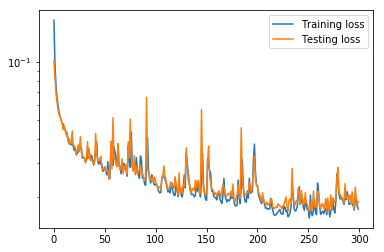

In [49]:
# Now let's train the initial network 

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 300

mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  20    # Number of pixels in each dimension of square patch
opts.delta                    =  .1   # Dirac delta relaxation parameter for rendering boundary maps

 
def get_loss(output_line_params, output_gt, opts, dev):
    
        # render ground truth boundaries (allows you to vary opts parameters rather than preload)
        jn_gt = MultiJunction(3, dev, output_gt[:,4:], output_gt[:,0], output_gt[:,1:4])
        b_gt = jn_gt.render_boundaries(opts,dev)

        # render output boundaries
        output_alpha = torch.atan2(output_line_params[:,1],output_line_params[:,0])
        jn = MultiJunction(3, dev, output_line_params[:,5:], output_alpha, output_line_params[:,2:5])
        b_output = jn.render_boundaries(opts,dev)
        
        loss = mse_loss(b_output,b_gt) 
        
        return loss

def forward_pass(data, opts, dev, training):
    
    # Load inputs from data
    inputs, output_gt, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()
    
    new_inputs = inputs 
    
    # forward pass to get outputs
    output_line_params = model(inputs)
    
    loss = get_loss(output_line_params,output_gt, opts, dev)
    
    if training:

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()
        
    return output_line_params, loss#, angles_gt_oh
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 50:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    model.train();
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        _,loss = forward_pass(data, opts, dev, training = 1)

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1    

            _,loss = forward_pass(data, opts, dev, training = 0)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)

    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

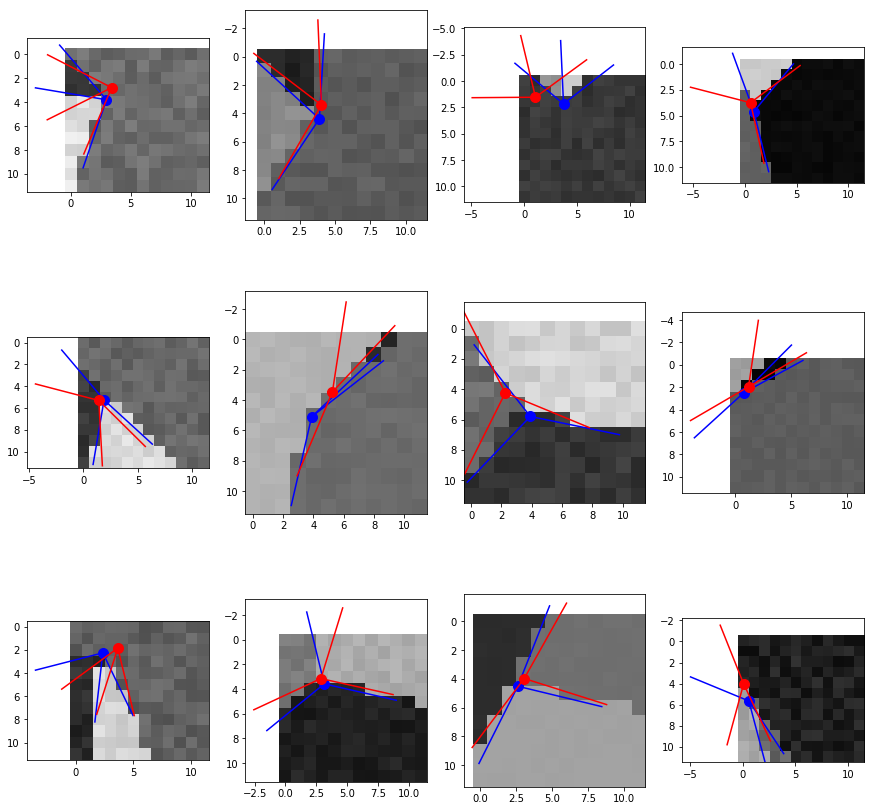

In [47]:
# Visualize the outputs

# First load one batch of outputs

model.eval();

data = next(iter(test_loader))

inputs, output_gt, _ = data
output_gt = output_gt.to(dev)

# forward pass to get outputs
outputs,_ = forward_pass(data, opts, dev, 0)

outputs = outputs.cpu().detach()
gt = output_gt.cpu().squeeze()


plt.figure(figsize=(15,15))

# Plot 10 examples of the outputs    
for ii in range(12):
    
    plt.subplot(3,4,ii+1)

    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray',vmin=0,vmax=1)

    center_gt = gt[ii][4:]*torch.tensor((H/2,W/2)) + torch.tensor((H/2,W/2))

    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    
    gt_angles = torch.stack((gt[:,0],gt[:,0]+gt[:,1],gt[:,0]+gt[:,1]+gt[:,2]),axis=1)
    
    line1_end = (center_gt + H/2*np.array([np.cos(gt_angles[ii][0]),np.sin(gt_angles[ii][0])]))
    line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_gt + H/2*np.array([np.cos(gt_angles[ii][1]),np.sin(gt_angles[ii][1])]))
    line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_gt + H/2*np.array([np.cos(gt_angles[ii][2]),np.sin(gt_angles[ii][2])]))
    line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-b')
    plt.plot(line2[0,:],line2[1,:],'-b')
    plt.plot(line3[0,:],line3[1,:],'-b')
    
    
    center_output = outputs[ii,5:]*torch.tensor((H/2,W/2)) + torch.tensor((H/2,W/2))
    
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    alpha = torch.atan2(outputs[:,1],outputs[:,0])
    
    output_angles = torch.stack((alpha, alpha + outputs[:,2],alpha + outputs[:,2] + outputs[:,3]),axis=1)
    
    line1_end = (center_output + H/2*np.array([np.cos(output_angles[ii][0]),np.sin(output_angles[ii][0])]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + H/2*np.array([np.cos(output_angles[ii][1]),np.sin(output_angles[ii][1])]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + H/2*np.array([np.cos(output_angles[ii][2]),np.sin(output_angles[ii][2])]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')

